In [1]:
# Necessary imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse

from torch import Tensor

from qiskit import Aer, QuantumCircuit, BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.multiclass_extensions import AllPairs
from qiskit.aqua.utils.dataset_helper import get_feature_dimension

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from quantic.data import DatasetLoader
    
# Additional torch-related imports
from torch import no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim # Adam, SGD, LBFGS
from torch.nn import NLLLoss # CrossEntropyLoss, MSELoss, L1Loss, BCELoss
from qnetworks import HybridQNN_Shallow
from qnetworks import HybridQNN

#time
import timeit


In [2]:
# network args
n_classes = 2
n_qubits = 2
n_features = None
if n_features is None:
    n_features = n_qubits
network = "hybridqnn_shallow" #hybridqnn_shallow
# train args
batch_size = 1
epochs = 10
LR = 0.001
n_samples_train = 200 #128
n_samples_test = 50 #64
# plot args
n_samples_show = batch_size
# dataset args
shuffle = True
dataset = "CIFAR100" # MNIST / CIFAR10 / CIFAR100, any from pytorch
dataset_cfg = ""
specific_classes_names = ["bicycle","motorcycle"] # ['0','1'] # selected (filtered) classes
print(specific_classes_names)
use_specific_classes = len(specific_classes_names)>=n_classes
# preprocessing
input_resolution = (28,28) #(28,28) # please check n_filts required on fc1/fc2 to input to qnn
resize_interpolation = transforms.functional.InterpolationMode.BILINEAR 

# Set seed for random generators
rand_seed = np.random.randint(50)
algorithm_globals.random_seed = rand_seed
manual_seed(rand_seed) # Set train shuffle seed (for reproducibility)

if not os.path.exists("plots"):
    os.mkdir("plots")

['bicycle', 'motorcycle']


In [3]:


######## PREPARE DATASETS
time_start = timeit.timeit()

# Train Dataset
# -------------

if dataset_cfg:
    # Load a dataset configuration file
    dataset = DatasetLoader.load(from_cfg=dataset_cfg,framework='torchvision')
else:
    # Or instantate dataset manually
    dataset = DatasetLoader.load(dataset_type=dataset,
                                   num_classes=n_classes,
                                   specific_classes=specific_classes_names,
                                   num_samples_class_train=n_samples_train,
                                   num_samples_class_test=n_samples_test,
                                   framework='torchvision'
                                   )
print(f'Dataset partitions: {dataset.get_partitions()}')

X_train = dataset['train']
X_test = dataset['test']


# Get channels (rgb or grayscale)
if len(X_train.data.shape)>3: # 3d image (rgb+)
    n_channels = X_train.data.shape[3]
else: # 2d image (grayscale)
    n_channels = 1

if network == 'hybridqnn_shallow' or network == 'QSVM':
    # Set preprocessing transforms
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
else:
    list_preprocessing = [
        transforms.Resize(input_resolution),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x),
    ] #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
X_train.transform= transforms.Compose(list_preprocessing)
X_test.transform = transforms.Compose(list_preprocessing)           

# set filtered/specific class names
classes_str = ",".join(dataset.specific_classes_names)
classes2spec = {}
specific_classes = dataset.specific_classes
for idx, class_idx in enumerate(specific_classes):
    classes2spec[class_idx]=idx

classes_list = dataset.classes
n_samples = n_samples_test

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Using downloaded and verified file: ./data/cifar-100-python.tar.gz
Extracting ./data/cifar-100-python.tar.gz to ./data
Dataset partitions: ['train', 'test']


In [4]:
# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=shuffle)
# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=shuffle)

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Dataloaders elapsed time: {time_elapsed} s")

Dataloaders elapsed time: 0.0025852309772744775 s


<Figure size 432x288 with 0 Axes>

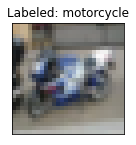

In [5]:
##### VISUALIZE LABELS
data_iter = iter(train_loader)
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    try:
        images, targets = data_iter.__next__()
    except:
        break
    plt.clf()
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for idx, image in enumerate(images):
        axes[idx].imshow(np.moveaxis(images[idx].numpy().squeeze(),0,-1))
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])
        class_label = classes_list[targets[idx].item()]
        axes[idx].set_title("Labeled: {}".format(class_label))
        if idx > n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_labeled_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            break
    plt.show()
    n_samples_show_alt -= 1
    

In [6]:
##### DESIGN NETWORK
time_start = timeit.timeit()



# init network
if network == "hybridqnn_shallow":
    ## predefine number of input filters to fc1 and fc2
    # examples: 13456 for (128x128x1), 59536 for (256x256x1), 256 for (28x28x1), 400 for (28x28x3) or (35x35x1) 
    if n_channels == 1:
        n_filts_fc1 = int(((((input_resolution[0]-4)/2)-4)/2)**2)*16
    else:
        #n_filts_fc1 = int(((((input_resolution[0])/2)-4)/2)**2)*16 # +7
        n_filts_fc1 = 256
    n_filts_fc2 = int(n_filts_fc1 / 4)

    # declare quantum instance
    qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))
    # Define QNN
    feature_map = ZZFeatureMap(n_features)
    ansatz = RealAmplitudes(n_qubits, reps=1)
    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = TwoLayerQNN(
        n_qubits, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
    )
    print(qnn.operator)
    qnn.circuit.draw(output="mpl",filename=f"plots/qnn{n_qubits}_{n_classes}classes.png")
    #from qiskit.quantum_info import Statevector
    #from qiskit.visualization import plot_bloch_multivector
    #state = Statevector.from_instruction(qnn.circuit)
    #plot_bloch_multivector(state)
    model = HybridQNN_Shallow(n_classes = n_classes, n_qubits = n_qubits, n_channels = n_channels, n_filts_fc1 = n_filts_fc1, n_filts_fc2 = n_filts_fc2, qnn = qnn)
    print(model)

    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_func = NLLLoss()

elif network == "QSVM":
    backend = BasicAer.get_backend('qasm_simulator')

    # todo: fix this transformation for QSVM
    train_input = X_train.targets
    test_input = X_test.targets
    total_array = np.concatenate([test_input[k] for k in test_input])
    #
    feature_map = ZZFeatureMap(feature_dimension=get_feature_dimension(train_input),
                               reps=2, entanglement='linear')
    svm = QSVM(feature_map, train_input, test_input, total_array,
               multiclass_extension=AllPairs())
    quantum_instance = QuantumInstance(backend, shots=1024,
                                       seed_simulator=algorithm_globals.random_seed,
                                       seed_transpiler=algorithm_globals.random_seed)
else:
    model = HybridQNN(backbone=network,pretrained=True,n_qubits=n_qubits,n_classes=n_classes)
    # Define model, optimizer, and loss function
    optimizer = optim.Adam(model.network.parameters(), lr=LR)
    loss_func = NLLLoss()
    
time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Network init elapsed time: {time_elapsed} s")

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])
HybridQNN_Shallow(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)
Network init elapsed time: 1.6599660739302635e-06 s


Batch 0, Loss: -1.212534785270691
Batch 1, Loss: -1.204883337020874
Batch 2, Loss: -1.2001348733901978
Batch 3, Loss: -1.3078863620758057
Batch 4, Loss: -1.286938190460205
Batch 5, Loss: 0.2696937620639801
Batch 6, Loss: 0.35107195377349854
Batch 7, Loss: 0.348338782787323
Batch 8, Loss: -1.3499846458435059
Batch 9, Loss: 0.31803587079048157
Batch 10, Loss: -1.3334612846374512
Batch 11, Loss: -1.3357789516448975
Batch 12, Loss: -1.3301243782043457
Batch 13, Loss: -1.319766640663147
Batch 14, Loss: -1.3508172035217285
Batch 15, Loss: -1.3367314338684082
Batch 16, Loss: 0.3498566150665283
Batch 17, Loss: 0.34401512145996094
Batch 18, Loss: -1.3395390510559082
Batch 19, Loss: -1.3268282413482666
Batch 20, Loss: -1.3329232931137085
Batch 21, Loss: 0.2781914174556732
Batch 22, Loss: -1.3619310855865479
Batch 23, Loss: -1.3608784675598145
Batch 24, Loss: 0.36144834756851196
Batch 25, Loss: -1.3524246215820312
Batch 26, Loss: -1.357405424118042
Batch 27, Loss: -1.3542943000793457
Batch 28, Lo

Batch 227, Loss: -1.1458320617675781
Batch 228, Loss: 0.24862298369407654
Batch 229, Loss: 0.1562686264514923
Batch 230, Loss: 0.1591666340827942
Batch 231, Loss: -1.2845388650894165
Batch 232, Loss: 0.2716577351093292
Batch 233, Loss: -1.428446650505066
Batch 234, Loss: -1.4273293018341064
Batch 235, Loss: 0.14747804403305054
Batch 236, Loss: -1.3231582641601562
Batch 237, Loss: 0.3110962212085724
Batch 238, Loss: 0.18045935034751892
Batch 239, Loss: -1.4220941066741943
Batch 240, Loss: -1.3017195463180542
Batch 241, Loss: 0.14135940372943878
Batch 242, Loss: 0.26609286665916443
Batch 243, Loss: 0.13939563930034637
Batch 244, Loss: 0.1876448392868042
Batch 245, Loss: 0.16585339605808258
Batch 246, Loss: 0.26796942949295044
Batch 247, Loss: -1.2773778438568115
Batch 248, Loss: 0.40692949295043945
Batch 249, Loss: -1.133301854133606
Batch 250, Loss: 0.3989039361476898
Batch 251, Loss: 0.246526300907135
Batch 252, Loss: -1.1718372106552124
Batch 253, Loss: 0.1386527568101883
Batch 254, L

Batch 52, Loss: 0.13365285098552704
Batch 53, Loss: 0.3839511275291443
Batch 54, Loss: -1.2580293416976929
Batch 55, Loss: -1.3887332677841187
Batch 56, Loss: 0.19573716819286346
Batch 57, Loss: 0.38619837164878845
Batch 58, Loss: -1.4323257207870483
Batch 59, Loss: -1.126522421836853
Batch 60, Loss: -1.4368884563446045
Batch 61, Loss: 0.40238475799560547
Batch 62, Loss: -1.126842975616455
Batch 63, Loss: 0.44617703557014465
Batch 64, Loss: 0.3881749212741852
Batch 65, Loss: 0.44745099544525146
Batch 66, Loss: -1.1365275382995605
Batch 67, Loss: -1.3870792388916016
Batch 68, Loss: -1.1551655530929565
Batch 69, Loss: 0.4199081063270569
Batch 70, Loss: 0.4422171711921692
Batch 71, Loss: -1.1302642822265625
Batch 72, Loss: 0.39761796593666077
Batch 73, Loss: 0.12867675721645355
Batch 74, Loss: -1.4424341917037964
Batch 75, Loss: 0.4417378306388855
Batch 76, Loss: -1.2210413217544556
Batch 77, Loss: 0.3932170569896698
Batch 78, Loss: 0.40859103202819824
Batch 79, Loss: 0.19278883934020996


Batch 277, Loss: -1.3404908180236816
Batch 278, Loss: 0.11478281766176224
Batch 279, Loss: -1.1212589740753174
Batch 280, Loss: 0.13019247353076935
Batch 281, Loss: -1.1145234107971191
Batch 282, Loss: 0.1146162673830986
Batch 283, Loss: 0.26045069098472595
Batch 284, Loss: 0.3452807366847992
Batch 285, Loss: 0.1288938820362091
Batch 286, Loss: -1.1148033142089844
Batch 287, Loss: 0.3525395393371582
Batch 288, Loss: -1.1159069538116455
Batch 289, Loss: 0.3404200077056885
Batch 290, Loss: 0.12704837322235107
Batch 291, Loss: 0.11620983481407166
Batch 292, Loss: 0.11854082345962524
Batch 293, Loss: -1.37288236618042
Batch 294, Loss: -1.3094364404678345
Batch 295, Loss: -1.124942421913147
Batch 296, Loss: -1.2479255199432373
Batch 297, Loss: 0.36562085151672363
Batch 298, Loss: -1.2496775388717651
Batch 299, Loss: -1.1210980415344238
Batch 300, Loss: -1.1114078760147095
Batch 301, Loss: 0.3544827997684479
Batch 302, Loss: 0.2756757140159607
Batch 303, Loss: 0.1135706678032875
Batch 304, L

Batch 103, Loss: 0.23197901248931885
Batch 104, Loss: -1.1282145977020264
Batch 105, Loss: 0.13091714680194855
Batch 106, Loss: 0.2406211793422699
Batch 107, Loss: 0.21779870986938477
Batch 108, Loss: -1.1209585666656494
Batch 109, Loss: 0.12753860652446747
Batch 110, Loss: 0.22556188702583313
Batch 111, Loss: 0.19534078240394592
Batch 112, Loss: 0.18347668647766113
Batch 113, Loss: -1.135793685913086
Batch 114, Loss: 0.1312498301267624
Batch 115, Loss: 0.12333772331476212
Batch 116, Loss: 0.15948225557804108
Batch 117, Loss: -1.1242719888687134
Batch 118, Loss: -1.1489896774291992
Batch 119, Loss: -1.1227765083312988
Batch 120, Loss: -1.1558995246887207
Batch 121, Loss: -1.1710214614868164
Batch 122, Loss: -1.166448950767517
Batch 123, Loss: -1.1743807792663574
Batch 124, Loss: -1.1309890747070312
Batch 125, Loss: 0.12644730508327484
Batch 126, Loss: 0.1311635822057724
Batch 127, Loss: -1.1811727285385132
Batch 128, Loss: 0.15793026983737946
Batch 129, Loss: -1.12513267993927
Batch 13

Batch 327, Loss: -1.1081643104553223
Batch 328, Loss: 0.17851658165454865
Batch 329, Loss: 0.11850392073392868
Batch 330, Loss: -1.1787753105163574
Batch 331, Loss: -1.120384693145752
Batch 332, Loss: -1.1355246305465698
Batch 333, Loss: -1.1174275875091553
Batch 334, Loss: -1.1504454612731934
Batch 335, Loss: 0.12338875979185104
Batch 336, Loss: 0.1245412528514862
Batch 337, Loss: -1.1300371885299683
Batch 338, Loss: -1.1085561513900757
Batch 339, Loss: 0.13114142417907715
Batch 340, Loss: -1.125254511833191
Batch 341, Loss: -1.1583701372146606
Batch 342, Loss: -1.2287156581878662
Batch 343, Loss: 0.13307832181453705
Batch 344, Loss: -1.1536545753479004
Batch 345, Loss: -1.1240208148956299
Batch 346, Loss: 0.16343018412590027
Batch 347, Loss: -1.1222307682037354
Batch 348, Loss: 0.16258504986763
Batch 349, Loss: -1.199780821800232
Batch 350, Loss: 0.1327463984489441
Batch 351, Loss: 0.15263065695762634
Batch 352, Loss: -1.1392544507980347
Batch 353, Loss: 0.13215571641921997
Batch 354

Batch 153, Loss: 0.3481502830982208
Batch 154, Loss: 0.2539401650428772
Batch 155, Loss: 0.24776160717010498
Batch 156, Loss: 0.316328763961792
Batch 157, Loss: -0.90087890625
Batch 158, Loss: -1.3996893167495728
Batch 159, Loss: -1.1658744812011719
Batch 160, Loss: -1.2931501865386963
Batch 161, Loss: 0.1424119919538498
Batch 162, Loss: -1.1195645332336426
Batch 163, Loss: -1.1166967153549194
Batch 164, Loss: 0.21887314319610596
Batch 165, Loss: 0.33665066957473755
Batch 166, Loss: -1.099471092224121
Batch 167, Loss: 0.28109902143478394
Batch 168, Loss: 0.16472332179546356
Batch 169, Loss: 0.11398059129714966
Batch 170, Loss: 0.15927404165267944
Batch 171, Loss: -1.1654114723205566
Batch 172, Loss: 0.109820157289505
Batch 173, Loss: -1.1155939102172852
Batch 174, Loss: -1.1120195388793945
Batch 175, Loss: -1.1007033586502075
Batch 176, Loss: -1.094788908958435
Batch 177, Loss: -1.1255600452423096
Batch 178, Loss: -1.1514010429382324
Batch 179, Loss: 0.10803577303886414
Batch 180, Loss

Batch 377, Loss: -1.2393720149993896
Batch 378, Loss: -1.1042604446411133
Batch 379, Loss: 0.1367911696434021
Batch 380, Loss: -1.3770726919174194
Batch 381, Loss: 0.31526169180870056
Batch 382, Loss: -1.103752613067627
Batch 383, Loss: 0.26419487595558167
Batch 384, Loss: -1.2063677310943604
Batch 385, Loss: -1.2530441284179688
Batch 386, Loss: 0.2672528326511383
Batch 387, Loss: 0.3770941197872162
Batch 388, Loss: 0.156741663813591
Batch 389, Loss: -1.2825772762298584
Batch 390, Loss: 0.31168586015701294
Batch 391, Loss: -1.2020987272262573
Batch 392, Loss: 0.3163706362247467
Batch 393, Loss: -1.104441523551941
Batch 394, Loss: -1.307072639465332
Batch 395, Loss: -1.3096725940704346
Batch 396, Loss: 0.25057584047317505
Batch 397, Loss: 0.11474383622407913
Batch 398, Loss: 0.12433023005723953
Batch 399, Loss: 0.10561929643154144
Training [40%]	Loss: -0.4996
Batch 0, Loss: 0.10412917286157608
Batch 1, Loss: 0.2845531404018402
Batch 2, Loss: -1.120989441871643
Batch 3, Loss: 0.175301581

Batch 203, Loss: 0.4107500910758972
Batch 204, Loss: 0.22022393345832825
Batch 205, Loss: -1.1044127941131592
Batch 206, Loss: -1.4267523288726807
Batch 207, Loss: 0.10355360060930252
Batch 208, Loss: 0.10441187769174576
Batch 209, Loss: 0.41552427411079407
Batch 210, Loss: 0.10334119200706482
Batch 211, Loss: -1.1038703918457031
Batch 212, Loss: -1.1025313138961792
Batch 213, Loss: 0.10288546234369278
Batch 214, Loss: -1.4324930906295776
Batch 215, Loss: 0.430205762386322
Batch 216, Loss: -1.1027806997299194
Batch 217, Loss: 0.10311771929264069
Batch 218, Loss: 0.4321293830871582
Batch 219, Loss: -1.4305317401885986
Batch 220, Loss: -1.427520751953125
Batch 221, Loss: 0.14384230971336365
Batch 222, Loss: 0.10276301950216293
Batch 223, Loss: 0.10871665924787521
Batch 224, Loss: 0.4087919294834137
Batch 225, Loss: -1.1150323152542114
Batch 226, Loss: 0.36493176221847534
Batch 227, Loss: -1.2377275228500366
Batch 228, Loss: 0.09996466338634491
Batch 229, Loss: -1.4309738874435425
Batch 2

Batch 27, Loss: 0.1917511522769928
Batch 28, Loss: 0.43819379806518555
Batch 29, Loss: -1.3919941186904907
Batch 30, Loss: 0.13217246532440186
Batch 31, Loss: 0.12062330543994904
Batch 32, Loss: 0.4580234885215759
Batch 33, Loss: -1.459869623184204
Batch 34, Loss: -1.1089328527450562
Batch 35, Loss: 0.45751291513442993
Batch 36, Loss: 0.10647265613079071
Batch 37, Loss: -1.105507254600525
Batch 38, Loss: 0.10500821471214294
Batch 39, Loss: 0.10621803253889084
Batch 40, Loss: -1.1051950454711914
Batch 41, Loss: -1.4480303525924683
Batch 42, Loss: 0.4385669529438019
Batch 43, Loss: 0.43716901540756226
Batch 44, Loss: -1.4333912134170532
Batch 45, Loss: -1.4330273866653442
Batch 46, Loss: -1.1027991771697998
Batch 47, Loss: -1.4337308406829834
Batch 48, Loss: -1.4351357221603394
Batch 49, Loss: -1.4363791942596436
Batch 50, Loss: -1.436627745628357
Batch 51, Loss: 0.4459129571914673
Batch 52, Loss: 0.10481996089220047
Batch 53, Loss: 0.44922471046447754
Batch 54, Loss: 0.45009392499923706

Batch 253, Loss: 0.33696603775024414
Batch 254, Loss: -1.4340224266052246
Batch 255, Loss: 0.31529709696769714
Batch 256, Loss: 0.3105313777923584
Batch 257, Loss: 0.4337483048439026
Batch 258, Loss: 0.4326961934566498
Batch 259, Loss: -1.299720048904419
Batch 260, Loss: -1.431962490081787
Batch 261, Loss: -1.2931690216064453
Batch 262, Loss: 0.2927711606025696
Batch 263, Loss: 0.42979931831359863
Batch 264, Loss: 0.42878013849258423
Batch 265, Loss: 0.4292523264884949
Batch 266, Loss: 0.27600568532943726
Batch 267, Loss: 0.27696356177330017
Batch 268, Loss: 0.42004624009132385
Batch 269, Loss: 0.2648286521434784
Batch 270, Loss: 0.4158574342727661
Batch 271, Loss: 0.4118729829788208
Batch 272, Loss: 0.4078965485095978
Batch 273, Loss: 0.23408690094947815
Batch 274, Loss: -1.3969401121139526
Batch 275, Loss: 0.23219892382621765
Batch 276, Loss: 0.39128077030181885
Batch 277, Loss: -1.3853765726089478
Batch 278, Loss: 0.38297387957572937
Batch 279, Loss: -1.1979161500930786
Batch 280, L

Batch 79, Loss: 0.36081087589263916
Batch 80, Loss: 0.16287006437778473
Batch 81, Loss: 0.19498616456985474
Batch 82, Loss: 0.1947360336780548
Batch 83, Loss: -1.3561570644378662
Batch 84, Loss: -1.1615562438964844
Batch 85, Loss: 0.3636150658130646
Batch 86, Loss: 0.1611672043800354
Batch 87, Loss: -1.3564454317092896
Batch 88, Loss: -1.1868226528167725
Batch 89, Loss: 0.18559443950653076
Batch 90, Loss: -1.3631064891815186
Batch 91, Loss: -1.156935691833496
Batch 92, Loss: -1.3590173721313477
Batch 93, Loss: 0.3659708499908447
Batch 94, Loss: 0.3608434796333313
Batch 95, Loss: 0.1838914155960083
Batch 96, Loss: 0.18395480513572693
Batch 97, Loss: 0.36483490467071533
Batch 98, Loss: 0.1764037013053894
Batch 99, Loss: -1.3572230339050293
Batch 100, Loss: 0.16744250059127808
Batch 101, Loss: -1.355918526649475
Batch 102, Loss: -1.1570452451705933
Batch 103, Loss: -1.3574600219726562
Batch 104, Loss: 0.355872243642807
Batch 105, Loss: -1.3558546304702759
Batch 106, Loss: -1.1417341232299

Batch 304, Loss: -1.3772039413452148
Batch 305, Loss: 0.3757012188434601
Batch 306, Loss: -1.1400917768478394
Batch 307, Loss: 0.38164180517196655
Batch 308, Loss: 0.37809574604034424
Batch 309, Loss: 0.38181743025779724
Batch 310, Loss: -1.3809863328933716
Batch 311, Loss: -1.380885124206543
Batch 312, Loss: -1.141189455986023
Batch 313, Loss: -1.141789436340332
Batch 314, Loss: -1.1429544687271118
Batch 315, Loss: 0.14454911649227142
Batch 316, Loss: -1.1453769207000732
Batch 317, Loss: 0.37934044003486633
Batch 318, Loss: 0.37923020124435425
Batch 319, Loss: 0.38188642263412476
Batch 320, Loss: 0.1501992642879486
Batch 321, Loss: -1.377440333366394
Batch 322, Loss: -1.3771791458129883
Batch 323, Loss: -1.3794384002685547
Batch 324, Loss: 0.15156377851963043
Batch 325, Loss: -1.1646933555603027
Batch 326, Loss: 0.37807098031044006
Batch 327, Loss: -1.1661972999572754
Batch 328, Loss: -1.1680331230163574
Batch 329, Loss: -1.380143165588379
Batch 330, Loss: 0.3785317540168762
Batch 331

Batch 130, Loss: 0.38189560174942017
Batch 131, Loss: -1.3897291421890259
Batch 132, Loss: -1.3849982023239136
Batch 133, Loss: 0.12636205554008484
Batch 134, Loss: 0.3982517421245575
Batch 135, Loss: -1.12276291847229
Batch 136, Loss: -1.1218558549880981
Batch 137, Loss: -1.1215825080871582
Batch 138, Loss: -1.40227472782135
Batch 139, Loss: 0.12167283147573471
Batch 140, Loss: 0.406009316444397
Batch 141, Loss: -1.1159428358078003
Batch 142, Loss: -1.406607985496521
Batch 143, Loss: 0.11610953509807587
Batch 144, Loss: 0.409435898065567
Batch 145, Loss: -1.4094648361206055
Batch 146, Loss: 0.4052225351333618
Batch 147, Loss: 0.12001744657754898
Batch 148, Loss: -1.4104729890823364
Batch 149, Loss: -1.4043149948120117
Batch 150, Loss: 0.11837151646614075
Batch 151, Loss: 0.11330024898052216
Batch 152, Loss: -1.412818193435669
Batch 153, Loss: 0.11154193431138992
Batch 154, Loss: 0.4180293679237366
Batch 155, Loss: 0.4225187301635742
Batch 156, Loss: -1.1119577884674072
Batch 157, Loss

Batch 355, Loss: 0.09485434740781784
Batch 356, Loss: -1.0940240621566772
Batch 357, Loss: 0.42768028378486633
Batch 358, Loss: -1.4274909496307373
Batch 359, Loss: 0.4276188611984253
Batch 360, Loss: 0.09510550647974014
Batch 361, Loss: 0.09416236728429794
Batch 362, Loss: -1.4268076419830322
Batch 363, Loss: 0.09360072761774063
Batch 364, Loss: 0.42668959498405457
Batch 365, Loss: 0.09278189390897751
Batch 366, Loss: 0.4257941246032715
Batch 367, Loss: -1.4250280857086182
Batch 368, Loss: 0.09174403548240662
Batch 369, Loss: -1.091124176979065
Batch 370, Loss: 0.09016941487789154
Batch 371, Loss: -1.424323320388794
Batch 372, Loss: -1.0898972749710083
Batch 373, Loss: 0.08919733762741089
Batch 374, Loss: -1.4244153499603271
Batch 375, Loss: 0.42399245500564575
Batch 376, Loss: -1.0890506505966187
Batch 377, Loss: -1.0884326696395874
Batch 378, Loss: -1.08857262134552
Batch 379, Loss: -1.0894800424575806
Batch 380, Loss: -1.425398349761963
Batch 381, Loss: 0.090497687458992
Batch 382,

Batch 181, Loss: 0.4403875470161438
Batch 182, Loss: -1.0938414335250854
Batch 183, Loss: -1.0941886901855469
Batch 184, Loss: 0.09545598179101944
Batch 185, Loss: 0.4402906894683838
Batch 186, Loss: -1.0951119661331177
Batch 187, Loss: -1.4405791759490967
Batch 188, Loss: 0.09667259454727173
Batch 189, Loss: 0.4407014548778534
Batch 190, Loss: -1.4403339624404907
Batch 191, Loss: 0.09615597873926163
Batch 192, Loss: 0.09607657790184021
Batch 193, Loss: -1.4402796030044556
Batch 194, Loss: 0.09564820677042007
Batch 195, Loss: -1.4395309686660767
Batch 196, Loss: 0.09506992995738983
Batch 197, Loss: -1.4408409595489502
Batch 198, Loss: -1.095059871673584
Batch 199, Loss: 0.09431388974189758
Batch 200, Loss: -1.0946918725967407
Batch 201, Loss: 0.09404349327087402
Batch 202, Loss: 0.09442052990198135
Batch 203, Loss: -1.4448524713516235
Batch 204, Loss: 0.09322236478328705
Batch 205, Loss: 0.09282414615154266
Batch 206, Loss: 0.09276928007602692
Batch 207, Loss: -1.0916248559951782
Batch

Batch 4, Loss: 0.4382621943950653
Batch 5, Loss: -1.0903211832046509
Batch 6, Loss: -1.439213752746582
Batch 7, Loss: 0.0920366421341896
Batch 8, Loss: -1.0921566486358643
Batch 9, Loss: -1.0927395820617676
Batch 10, Loss: 0.4420716166496277
Batch 11, Loss: 0.44274473190307617
Batch 12, Loss: 0.09439259767532349
Batch 13, Loss: -1.0949528217315674
Batch 14, Loss: -1.095314860343933
Batch 15, Loss: -1.4423739910125732
Batch 16, Loss: 0.44330894947052
Batch 17, Loss: -1.4428396224975586
Batch 18, Loss: 0.09719782322645187
Batch 19, Loss: 0.09697868674993515
Batch 20, Loss: -1.4441574811935425
Batch 21, Loss: 0.09748490899801254
Batch 22, Loss: 0.09737443178892136
Batch 23, Loss: -1.4446626901626587
Batch 24, Loss: 0.4451324939727783
Batch 25, Loss: -1.0963430404663086
Batch 26, Loss: -1.445446252822876
Batch 27, Loss: -1.0963841676712036
Batch 28, Loss: -1.4463754892349243
Batch 29, Loss: -1.0972038507461548
Batch 30, Loss: -1.0976470708847046
Batch 31, Loss: -1.097945213317871
Batch 32,

Batch 231, Loss: 0.09409158676862717
Batch 232, Loss: -1.093536376953125
Batch 233, Loss: 0.09273087978363037
Batch 234, Loss: 0.3325875997543335
Batch 235, Loss: 0.33280155062675476
Batch 236, Loss: -1.3317205905914307
Batch 237, Loss: -1.3314708471298218
Batch 238, Loss: 0.33185505867004395
Batch 239, Loss: 0.3312509059906006
Batch 240, Loss: 0.3308316171169281
Batch 241, Loss: 0.08974922448396683
Batch 242, Loss: 0.08755651861429214
Batch 243, Loss: 0.08817166835069656
Batch 244, Loss: -1.0858452320098877
Batch 245, Loss: -1.085231900215149
Batch 246, Loss: 0.32752224802970886
Batch 247, Loss: -1.0856174230575562
Batch 248, Loss: 0.08547370880842209
Batch 249, Loss: -1.3259515762329102
Batch 250, Loss: -1.325758934020996
Batch 251, Loss: -1.084733486175537
Batch 252, Loss: 0.08485546708106995
Batch 253, Loss: -1.325976848602295
Batch 254, Loss: -1.0847049951553345
Batch 255, Loss: -1.3265477418899536
Batch 256, Loss: -1.3272477388381958
Batch 257, Loss: -1.0855151414871216
Batch 258

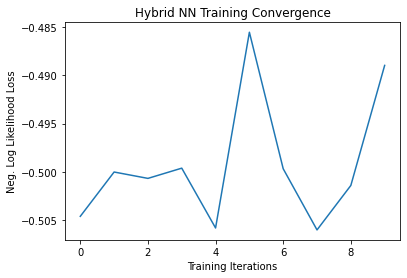

Training time: 0.006199120020028204 s


In [7]:
################# TRAIN
# Start training
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.train()  # Set model to training mode
    if network == "hybridqnn_shallow":
        model.train()  # Set model to training mode
        
    loss_list = []  # Store loss history
    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(data)  # Forward pass
            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            loss = loss_func(output, target)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss
            print(f"Batch {batch_idx}, Loss: {total_loss[-1]}")
        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    # Plot loss convergence
    plt.clf()
    plt.plot(loss_list)
    plt.title("Hybrid NN Training Convergence")
    plt.xlabel("Training Iterations")
    plt.ylabel("Neg. Log Likelihood Loss")
    #plt.savefig(f"plots/{dataset}_classification{classes_str}_hybridqnn_q{n_qubits}_{n_samples}samples_lr{LR}_bsize{batch_size}.png")
    plt.show()
    
elif network == "QSVM":
    result = svm.run(quantum_instance)
    for k,v in result.items():
        print(f'{k} : {v}')

time_end = timeit.timeit()
time_elapsed = time_end - time_start
print(f"Training time: {time_elapsed} s")

In [8]:
######## TEST
time_start = timeit.timeit()

if network != "QSVM":
    if "vgg" in network or "resnet" in network:
        model.network.eval()  # Set model to eval mode
    if network == "hybridqnn_shallow":
        model.eval()  # Set model to eval mode
    with no_grad():
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            if len(output.shape) == 1:
                output = output.reshape(1, *output.shape)
            pred = output.argmax(dim=1, keepdim=True)

            # change target class identifiers towards 0 to n_classes
            for sample_idx, value in enumerate(target):
                target[sample_idx]=classes2spec[target[sample_idx].item()]

            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

    time_end = timeit.timeit()
    time_elapsed = time_end - time_start
    print(f"Test time: {time_elapsed} s")
    
    


Performance on test data:
	Loss: -0.4912
	Accuracy: 50.0%
Test time: -0.0009709650184959173 s


<Figure size 432x288 with 0 Axes>

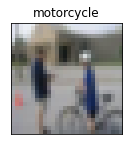

In [9]:
# Plot predicted labels
n_samples_show_alt = n_samples_show
while n_samples_show_alt > 0:
    plt.clf()
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(n_samples_show*2, batch_size*3))
    if n_samples_show == 1:
        axes = [axes]
    for batch_idx, (data, target) in enumerate(test_loader):    
        if count == n_samples_show:
            #plt.savefig(f"plots/{dataset}_classification{classes_str}_subplots{n_samples_show_alt}_lr{LR}_pred_q{n_qubits}_{n_samples}samples_bsize{batch_size}_{epochs}epoch.png")
            plt.show()
            break
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)
        pred = output.argmax(dim=1, keepdim=True)
        for sample_idx in range(batch_size):
            try:
                class_label = classes_list[specific_classes[pred[sample_idx].item()]]
            except:
                class_label = classes_list[specific_classes[pred[sample_idx].item()-1]]
            axes[count].imshow(np.moveaxis(data[sample_idx].numpy().squeeze(),0,-1))
            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title(class_label)
            count += 1
    n_samples_show_alt -= 1

### 